# Goal of Project

이번 연구의 주제는 주어진 부산시의 기온데이터를 통해 평균기온을 예측하는 모형을 개발하는 것이다. 이로서 부산시의 평균기온이 알고 싶을 때 주어진 모형을 사용하여 예측할 수 있을 것이다.

이때, 고전적인 시계열 분석 모형의 성능과 딥러닝 모형의 성능을 비교하는 것에 초점을 맞추고 분석을 진행한다.

# Data Description

주어진 데이터는 2019년 01월 01일부터 2021년 12월 31일까지 부산광역시의 평균기온(°C), 최저기온(°C), 최고기온(°C)을 담고 있는 데이터이다. 따라서 총 1096개의 행과 4개의 열로 구성되어 있다.

In [34]:
# 초기 세팅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [35]:
data = pd.read_csv('부산_평균기온_최저기온_최고기온_2019-2021.csv', encoding='CP949')
data.shape

(1096, 4)

In [36]:
data.head()

,일시,평균기온(°C),최저기온(°C),최고기온(°C)
0,2019-01-01,1.0,-1.9,5.5
1,2019-01-02,1.2,-2.5,6.4
2,2019-01-03,3.0,-1.7,8.4
3,2019-01-04,5.0,1.4,8.2
4,2019-01-05,5.5,2.2,10.7


In [37]:
# Data preprocessing
data.columns = ['Date', 'mean_temp', 'min_temp', 'max_temp']
data["Date"] = pd.to_datetime(data["Date"])
data.head()

,Date,mean_temp,min_temp,max_temp
0,2019-01-01,1.0,-1.9,5.5
1,2019-01-02,1.2,-2.5,6.4
2,2019-01-03,3.0,-1.7,8.4
3,2019-01-04,5.0,1.4,8.2
4,2019-01-05,5.5,2.2,10.7


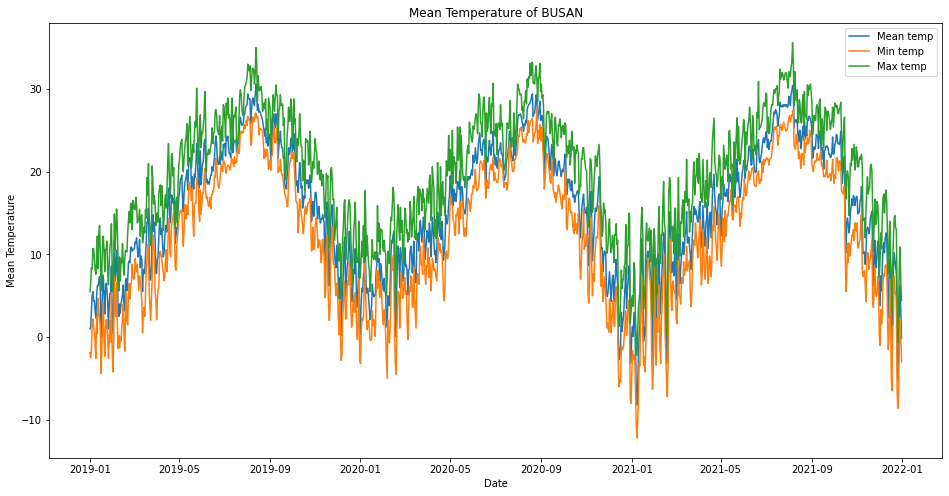

In [38]:
# Visualization
plt.figure(figsize=(16,8))
plt.plot(data.Date, data.mean_temp)
plt.plot(data.Date, data.min_temp)
plt.plot(data.Date, data.max_temp)
plt.title("Mean Temperature of BUSAN")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend(labels=["Mean temp","Min temp","Max temp"])
plt.show()

# Modeling

부산시 평균 기온 예측 모형개발에 사용될 모델들은 다음과 같다. 

- ARIMA : 고전적인 '시계열' 예측 모형


- LSTM : 딥러닝을 활용한 '시계열' 예측 모형

위 두가지 모형을 사용하게 된 이유는 첫째로 고전적인 시계열 예측모형과 딥러닝 모형이 예측결과가 어떤 차이를 보여줄지가 궁금했기 때문이다. 둘째로는 딥러닝으로 시계열 데이터를 예측하는 데에는 보편적으로 LSTM 모형이 자주 사용되어 왔기 때문이다.

위의 모형들을 데이터에 알맞게 훈련시킨 뒤 평가지표를 가지고 가장 최적의 모형을 식별한다. 

우선 현재의 데이터를 Train/Valid/Test set으로 8:1:1 비율로 분할하자. 데이터의 개수가 작기 때문에 Valid/Test set은 적은 비율을 차지한다.

In [39]:
train_index = round(data.shape[0] * 0.8) ; valid_index = round(data.shape[0] * 0.9)
train = data[:train_index] ; valid = data[train_index:valid_index] ; test = data[valid_index:]
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f'Train shape : {train.shape} \nValid shape : {valid.shape} \nTest shape : {test.shape}')

Train shape : (877, 4) 
Valid shape : (109, 4) 
Test shape : (110, 4)


평가지표로는 RMSE(Root Mean Squared Error)와 MAPE(Mean Absolute Percentage Error)를 채택한다.

- RMSE(Root Mean Squared Error) : 지표 자체가 직관적이고 단순하다.

    $RMSE=\sqrt{\frac{1}{n}\displaystyle\sum_{i=1}^{n} (y_i-\hat{y}_i)^2}$


- MAPE(Mean Absolute Percentage Error) : 변수의 스케일의 영향을 받지 않는다.

    $MAPE=\frac{1}{n}\displaystyle\sum_{i=1}^{n} |\frac{y_i-\hat{y}_i}{y_i}|$

RMSE는 단순하지만 스케일의 영향을 받고, MAPE는 변수의 스케일의 영향을 받지 않으므로 상호간에 보완이 가능하다. 따라서 두 지표를 채택한다.

In [40]:
# 성능 평가 함수
from sklearn import metrics

def scoring(y_true, y_pred, model):
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred)*100, 3)

    df = pd.DataFrame({"RMSE":rmse, "MAPE":mape}, index=[f'{model}'])

    return df

## ARIMA

<Figure size 432x288 with 0 Axes>

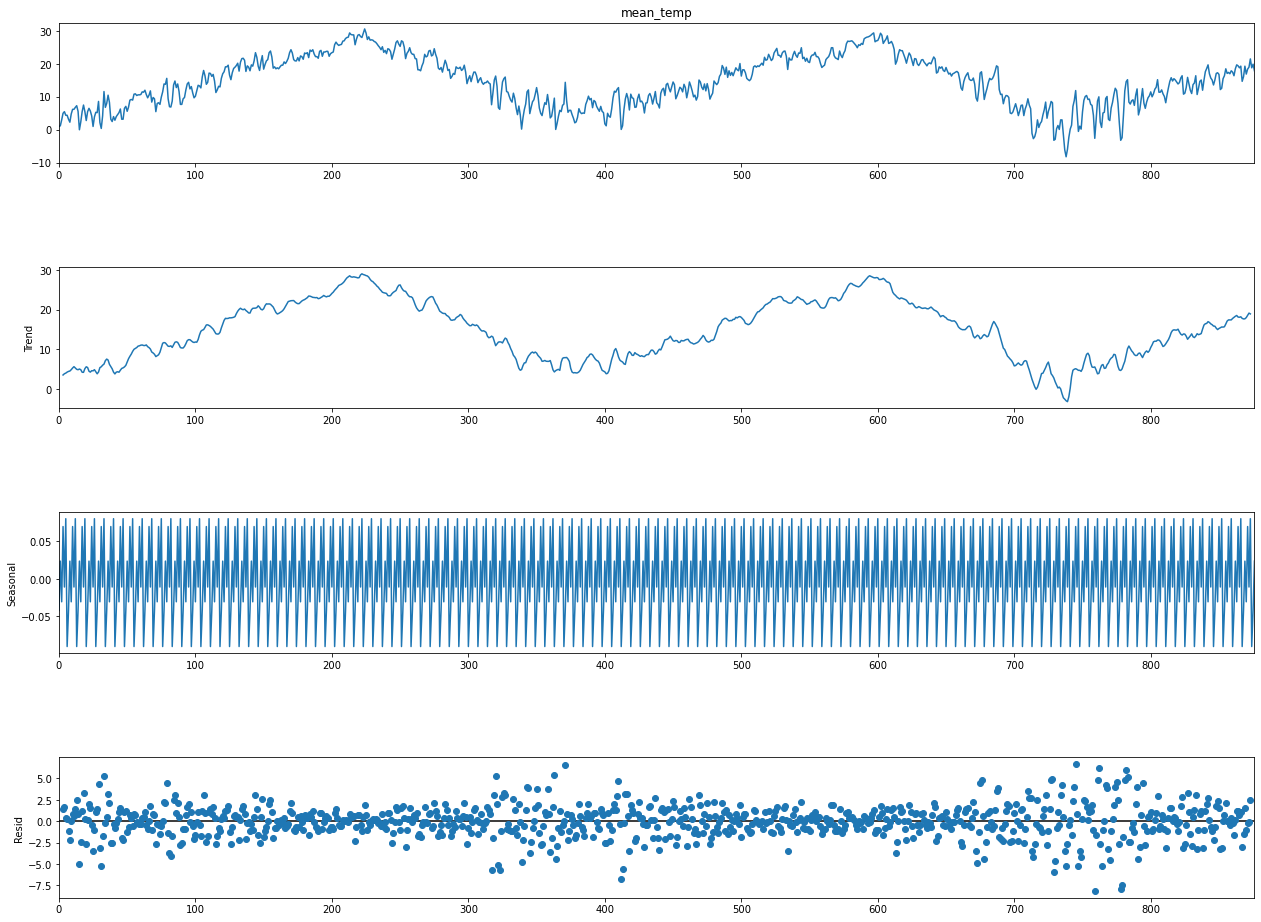

In [41]:
# 계절성 분해
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train['mean_temp'], model='additive', freq=7)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)

그래프를 확인해 보았을 때 특정 패턴이 존재한다. 기온 데이터라 어쩌면 직관적인 결과이다. 데이터의 패턴은 정상성에 의심을 야기하므로 이를 판단하기 위해 ACF 그래프를 그려보자.

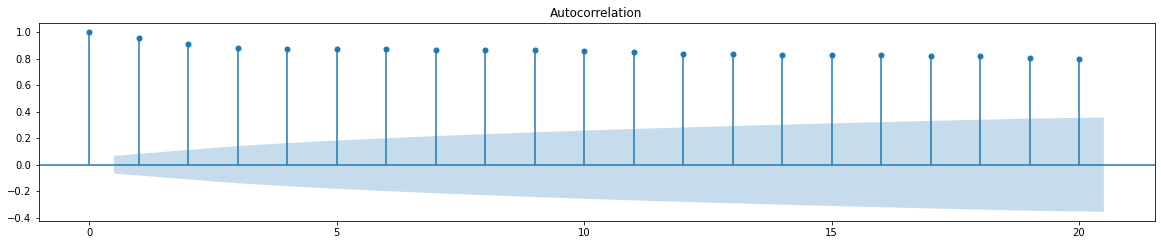

In [42]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train['mean_temp'], lags=20, ax=ax1)

ACF의 값이 아주 천천히 작아지는 것을 알 수 있다. 즉 정상성을 만족하지 않는다.

정량적인 판단 또한 필요하므로 정상성을 판단하는 단위근 검정인 ADF(Augmented Dickey-Fuller)test를 실시해보자.

In [43]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train['mean_temp'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {round(value, 3)}')

ADF Statistic: -2.049500458248717
p-value: 0.2652991514719423
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


p-value가 0.05를 넘으므로 귀무가설인 정상성만족을 기각한다. 즉 해당 데이터는 정상성을 만족하지 않는다. 따라서 1차 차분을 시행해보자.

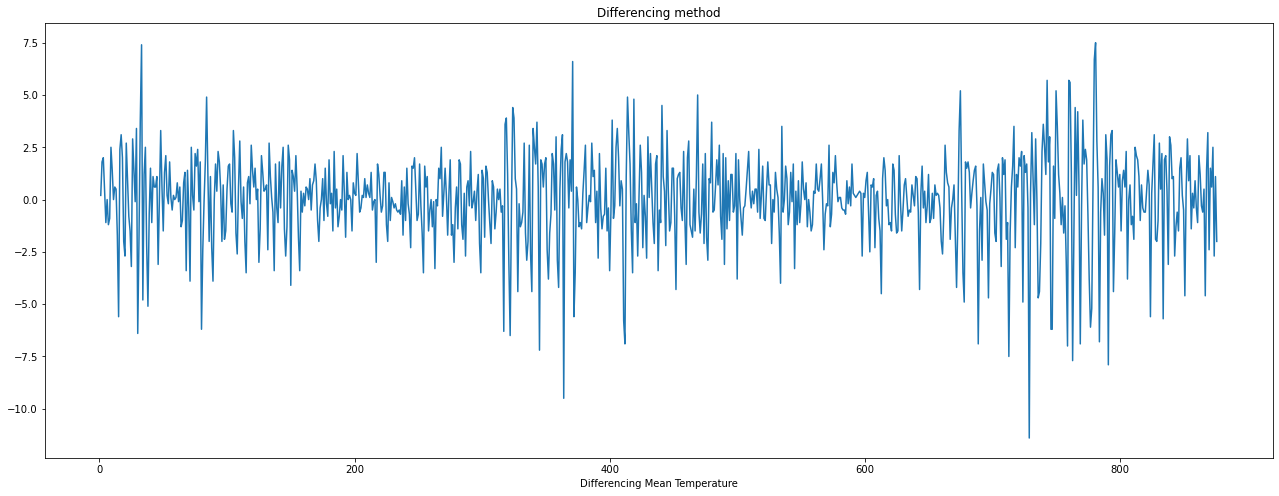

In [44]:
diff = train['mean_temp'] - train['mean_temp'].shift()
plt.figure(figsize=(22,8))
plt.plot(diff)
plt.title("Differencing method")
plt.xlabel("Date")
plt.xlabel("Differencing Mean Temperature")
plt.show()

일정한 패턴이 확인되지 않고, 나름대로 정상성을 만족하는 듯 보인다. ADF 검정 결과를 확인해보자.

In [45]:
result = adfuller(diff[1:])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {round(value, 3)}')

ADF Statistic: -15.71722298453241
p-value: 1.3372921182191863e-28
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


p-value가 매우 작으므로 귀무가설을 기각한다. 즉, 1차 차분한 데이터는 정상성을 만족한다.

이제 ARIMA 모형의 차수 p와 q를 결정하자.

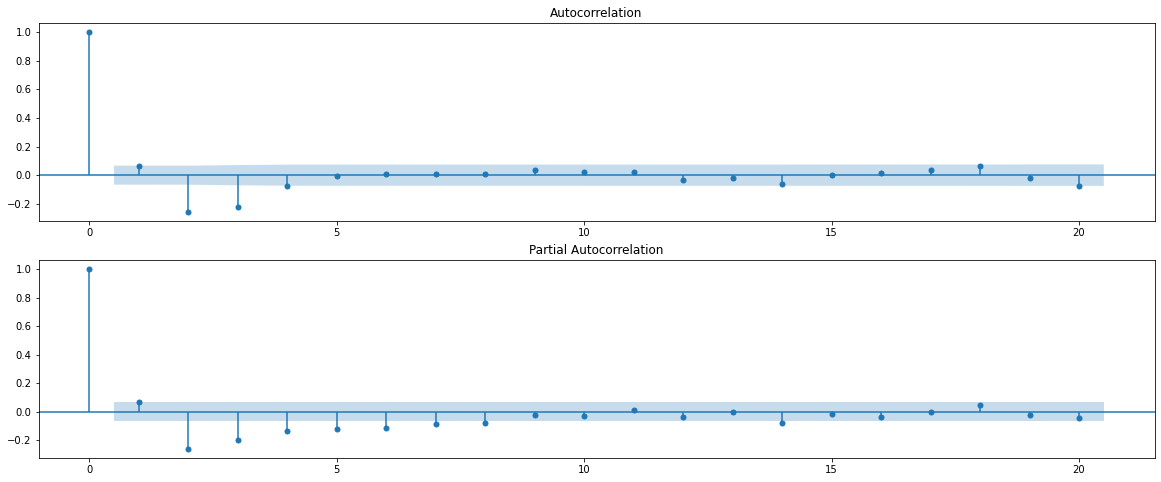

In [46]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff[1:], lags=20, ax=ax2)

ACF와 PACF 모두 금방 0에 수렴하는데, 2~3번째 lag 이후 0에 수렴한다.

따라서 ARIMA(1,1,1), ARIMA(2,1,1), ARIMA(1,1,2), ARIMA(2,1,2)등의 모델을 검증데이터에 시도해보자.

In [47]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime
pdq = [(1,1,1), (2,1,1), (1,1,2), (2,1,2)]

for i in range(len(pdq)):
    model  = ARIMA(train['mean_temp'], order=pdq[i]) #fit model
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=len(valid))
    globals()[f'scoring_df{i}'] = scoring(valid["mean_temp"], forecast, model=''.join(str(pdq[i])))

arima_score = pd.concat([scoring_df0, scoring_df1, scoring_df2, scoring_df3])

In [48]:
arima_score

,RMSE,MAPE
"(1, 1, 1)",6.815,24.478
"(2, 1, 1)",6.619,23.568
"(1, 1, 2)",6.788,24.323
"(2, 1, 2)",6.602,23.489


성능 평가지표에서 ARIMA(2,1,2)가 가장 좋은 성능을 보였으므로 ARIMA(2,1,2) 모형을 채택하기로한다.

## LSTM

LSTM 모형에서는 최저기온과 최고기온 데이터를 Feature로 하여 평균기온을 예측해보자.

최저기온과 최고기온의 크기가 서로 다르므로 적절한 훈련을 위해 MinMaxScailing을 통해 0~1 사이의 값으로 스케일링 한다.

In [49]:
from sklearn.preprocessing import MinMaxScaler
# Input Scale
scaler_x = MinMaxScaler()
scaler_x.fit(train[["min_temp", "max_temp"]])

train_x = scaler_x.transform(train[["min_temp", "max_temp"]])
val_x = scaler_x.transform(valid[["min_temp", "max_temp"]])
test_x = scaler_x.transform(test[["min_temp", "max_temp"]])

# OUtput Scale
scaler_y = MinMaxScaler()
scaler_y.fit(train[["mean_temp"]])

train_y = scaler_y.transform(train[["mean_temp"]])
val_y = scaler_y.transform(valid[["mean_temp"]])
test_y = scaler_y.transform(test[["mean_temp"]])

PyTorch Framework사용을 위해 Numpy배열을 Tensor형태로 바꿔준다.

In [51]:
train_x_tensor = Variable(torch.Tensor(train_x))
val_x_tensor = Variable(torch.Tensor(val_x))
test_x_tensor = Variable(torch.Tensor(test_x))

train_y_tensor = Variable(torch.Tensor(train_y))
val_y_tensor = Variable(torch.Tensor(val_y))
test_y_tensor = Variable(torch.Tensor(test_y))

X_train = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))
X_val = torch.reshape(val_x_tensor, (val_x_tensor.shape[0], 1, val_x_tensor.shape[1]))
X_test = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))

print("Training Shape :", X_train.shape, train_y_tensor.shape)
print("Validation Shape :", X_val.shape, val_y_tensor.shape)
print("Testing Shape :", X_test.shape, test_y_tensor.shape)

Training Shape : torch.Size([877, 1, 2]) torch.Size([877, 1])
Validation Shape : torch.Size([109, 1, 2]) torch.Size([109, 1])
Testing Shape : torch.Size([110, 1, 2]) torch.Size([110, 1])


In [ ]:
def train_LSTM(num_epochs, learning_rate):
  for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = loss_function(outputs, train_y_tensor.to(device))

    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop
#    if epoch % 100 == 0:
#      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

In [52]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


LSTM구조를 정의하는 Class를 구현해보자.

In [53]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

다음은 네트워크를 구성하는 파라미터들이다.

In [54]:
num_epochs = 10000 #2000 epochs
learning_rate = 0.0001 #0.0001 lr

input_size = 2 #number of features
hidden_size = 10 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

학습을 시작해보자.

In [55]:
def train_LSTM(num_epochs, learning_rate):
  for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = loss_function(outputs, train_y_tensor.to(device))

    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop
#    if epoch % 100 == 0:
#      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

In [56]:
def validation(num_epochs, learning_rate):
    train_LSTM(num_epochs, learning_rate)
    Valid_predict = lstm1(X_val.to(device)) #forward pass
    Valid_predict = Valid_predict.data.detach().cpu().numpy()
    Valid_predict = scaler_y.inverse_transform(Valid_predict)
    scoring_df = scoring(valid["mean_temp"], Valid_predict, model=f'LSTM({learning_rate} / {num_epochs})')
    return scoring_df

In [57]:
num_epoch = [1000, 2000, 5000, 10000] 
learning_rates = [0.01, 0.001, 0.0001] 

for i in range(len(num_epoch)):
    for j in range(len(learning_rates)):
        globals()[f'scoring_df{i}{j}'] = validation(num_epoch[i], learning_rates[j])

In [58]:
scoring_df = scoring_df00

for i in range(len(num_epoch)):
    for j in range(len(learning_rates)):
        scoring_df = pd.concat([scoring_df, globals()[f'scoring_df{i}{j}']])

LSTM_score = scoring_df
LSTM_score

,RMSE,MAPE
LSTM(0.01 / 1000),8.187,31.262
LSTM(0.01 / 1000),8.187,31.262
LSTM(0.001 / 1000),3.489,13.121
LSTM(0.0001 / 1000),0.392,1.333
LSTM(0.01 / 2000),0.375,1.294
LSTM(0.001 / 2000),0.370,1.274
LSTM(0.0001 / 2000),0.364,1.257
LSTM(0.01 / 5000),0.349,1.201
LSTM(0.001 / 5000),0.346,1.183
LSTM(0.0001 / 5000),0.344,1.177


Learning rate가 낮을 수록, Epoch이 많이 진행될수록 성능이 좋아지는 모습을 알 수 있다. 특히 learning rate가 크고(0.01) Epoch가 적은(1000) 모델은 ARIMA(2,1,2)모형보다 성능이 좋지 않은 것을 알 수 있다. 

가장 성능이 좋은 모델은 learning_rate가 0.0001이고 epoch가 10000인 LSTM 모형이다. 따라서 이 모델을 채택하기로 한다.

이제 TestDataset에 우리가 채택한 모델 두가지를 적용하고 성능을 비교해보자.

In [59]:
train = pd.concat([train, valid], ignore_index=True)

In [68]:
# Input Scale
scaler_x = MinMaxScaler()
scaler_x.fit(train[["min_temp", "max_temp"]])

train_x = scaler_x.transform(train[["min_temp", "max_temp"]])
test_x = scaler_x.transform(test[["min_temp", "max_temp"]])

# OUtput Scale
scaler_y = MinMaxScaler()
scaler_y.fit(train[["mean_temp"]])

train_y = scaler_y.transform(train[["mean_temp"]])
test_y = scaler_y.transform(test[["mean_temp"]])

train_x_tensor = Variable(torch.Tensor(train_x))
test_x_tensor = Variable(torch.Tensor(test_x))

train_y_tensor = Variable(torch.Tensor(train_y))
test_y_tensor = Variable(torch.Tensor(test_y))

X_train = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))
X_test = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))

In [106]:
# arima test
arima = ARIMA(train["mean_temp"], order=(2,1,2)) #fit model
arima_fit = arima.fit()
forecast = arima_fit.forecast(steps=len(test))
arima_final_score = scoring(test["mean_temp"], forecast, model='ARIMA(2,1,2)')

# LSTM test
train_LSTM(num_epochs=10000, learning_rate=0.0001)
predict = lstm1(X_test.to(device)) #forward pass
predict = predict.data.detach().cpu().numpy()
predict = scaler_y.inverse_transform(predict)
predict = np.array(predict.flatten())
LSTM_final_score = scoring(test["mean_temp"], predict, model='LSTM(lr=0.0001, epoch=10000)')

score = pd.concat([arima_final_score, LSTM_final_score])    

In [107]:
score

,RMSE,MAPE
"ARIMA(2,1,2)",12.399,385.436
"LSTM(lr=0.0001, epoch=10000)",0.461,8.363


성능의 차이가 꽤나 심하게 차이가난다. 실제 기온예측 값들을 시각화해보자.

In [108]:
pred_result = pd.DataFrame({'Date':np.array(test["Date"]), 'true_value':np.array(test["mean_temp"]), 'ARIMA_predict':np.array(forecast), 'LSTM_predict':predict})
pred_result

,Date,true_value,ARIMA_predict,LSTM_predict
0,2021-09-13,23.6,24.539525,23.854595
1,2021-09-14,21.5,24.228338,21.748602
2,2021-09-15,22.9,24.100136,23.222530
3,2021-09-16,22.7,24.103990,22.069168
4,2021-09-17,20.3,24.151792,20.849693
...,...,...,...,...
105,2021-12-27,-1.8,24.191181,-2.254115
106,2021-12-28,3.9,24.191181,3.378242
107,2021-12-29,6.2,24.191181,6.000897
108,2021-12-30,2.8,24.191181,3.129745


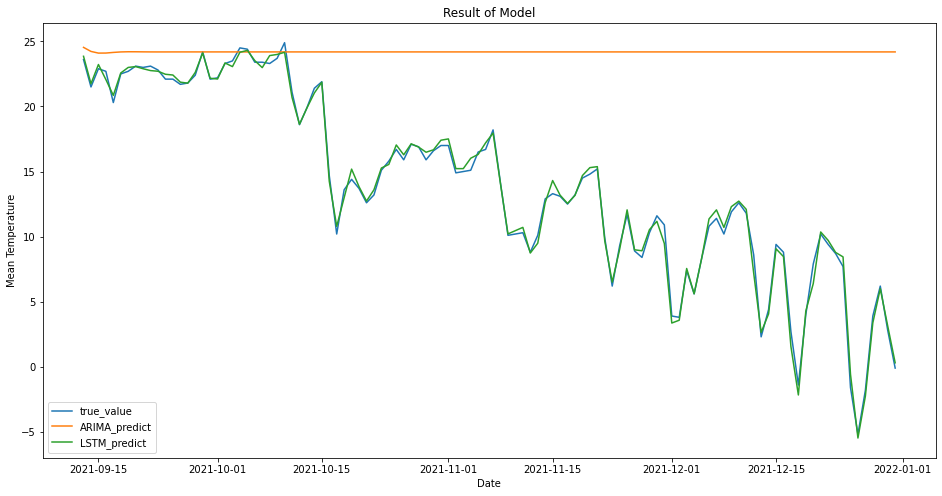

In [109]:
# Visualization
plt.figure(figsize=(16,8))
plt.plot(pred_result.Date, pred_result.true_value)
plt.plot(pred_result.Date, pred_result.ARIMA_predict)
plt.plot(pred_result.Date, pred_result.LSTM_predict)
plt.title("Result of Model")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend(labels=["true_value","ARIMA_predict","LSTM_predict"])
plt.show()

# Conclusion

ARIMA 모형의 경우 기온 예측의 값이 'stuck' 상태이다. 일정 값 이상에서 전혀 변화가 일어나지 않는 모습을 보여주고 있으며, 반면에 LSTM 모형의 경우 평균기온 예측이 매우 잘 된 상황이다.

따라서 우리는 부산시의 평균기온 예측 모형을 LSTM 모형으로 선정해야 함을 알 수 있다. 이는 시각화 뿐만 아니라 기존의 성능지표의 결과로도 합리적인 선택이다.

# Retrospect

LSTM 모형의 경우에는 최저기온과 최고기온을 feature로 사용하여 학습을 진행하였다. 때문에 사실 학습이 잘되는 것이 당연한 사실이였고, ARIMA와 결과 비교를 하는것이 불합리적이라는 생각이 들었다.

또한 ARIMA모형에 대한 깊은 이해가 조금 더 필요하겠다는 생각이 들었으며, 왜 'ARIMA' 모형이 24도 언저리에 머물러있는지에 대한 원인을 알아볼 필요가 있다.

분석을 진행하며 개략적인 시계열데이터 예측과정에 대한 프로세스를 배울 수 있어 보람찼고 부족한 부분을 잘 알아차릴 수 있어 보람찬 프로젝트였다.